In [ ]:
import pandas as pd
import numpy as np
import re
import string
from gensim.models import Word2Vec
from nltk import word_tokenize
from nltk.corpus import stopwords
import nltk
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Read Data

In [ ]:
datadf = pd.read_csv("data/MenuItem.csv")

In [ ]:
datadf

,Restaurant Name,Original food Item
0,Coffee Time,Garden Vegetable Sandwich
1,HoSan,Roasted Seaweed Snack
2,Weight Watchers,Muffins
3,Natural Sea,"Albacore Tuna, Solid White"
4,World of Beer,Caesar Salad with Grilled Flat Iron Steak
...,...,...
4519,Moxie's Classic Grill,Spring Mix Starter Salad
4520,Thundercloud Subs,"Genoa Salami Low-Fat Sub, Large"
4521,Chick-fil-A,"Cookies & Cream Milkshake, Small"
4522,Cereality,2% Milk


# Data exploration

In [ ]:
len(datadf['Restaurant Name'].unique())

341

In [ ]:
datadf.isnull().sum().sum()

0


### Summary
*  341 unique restaurants
*  Dataset contains no null values.





# Preprocessing

In [ ]:
def clean_text(text, tokenizer, stopwords):
    """Pre-process text and generate tokens

    Args:
        text: Text to tokenize.

    Returns:
        Tokenized text.
    """
    text = str(text).lower()  # Lowercase words
    text = re.sub(
        f"[{re.escape(string.punctuation)}]", "", text
    )  # Remove punctuation

    tokens = tokenizer(text)  # Get tokens from text
    tokens = [t for t in tokens if not t in stopwords]  # Remove stopwords
    tokens = ["" if t.isdigit() else t for t in tokens]  # Remove digits
    tokens = [t for t in tokens if len(t) > 1]  # Remove short tokens
    return tokens

In [ ]:
custom_stopwords = set(stopwords.words("english") + [])

datadf["Original food Item"] = datadf["Original food Item"].map(lambda x: clean_text(x, word_tokenize, custom_stopwords))


In [ ]:
datadfc = datadf.groupby('Restaurant Name')["Original food Item"].apply(lambda x: list(x))

In [ ]:
datadfcombined = datadf.groupby('Restaurant Name').agg({"Original food Item": 'sum'}).reset_index()
datadfcombined["Original food Item"] = datadfcombined["Original food Item"].map(lambda x: np.unique(x))
datadfcombined["Original food Item"] = datadfcombined["Original food Item"].map(lambda x: ' '.join(x))

In [ ]:
datadfcombined

,Restaurant Name,Original food Item
0,241 Pizza,bacon based basil bbq bread buffalo canadian c...
1,A&W (Canada),apple aw bacon beer beyond blt bonein breakfas...
2,Amay's,almond cookies
3,Ameci Pizza & Pasta,alfredo ameci antipasto ball bread caesar calz...
4,America's Taco Shop,al asada bean beans bread burrito carne cevich...
...,...,...
336,Yellow Tail,grigio moscato pinot
337,YoCream,acai almondmilk batter bean berry blueberry br...
338,Yogli Mogli,acai angel batter berry blackberry blueberry b...
339,Yoshinoya,asian bbq beef bowl brisk brown butter cake ca...



### Preprocessing Summary
*  All words are changed to lowercase.
*  Removed all characters/punctuations and digits.
*  Removed all stop words.
*  Combined the restaurant's menu into a single string, producing 341 rows.

# Embeddings

## Experiment 1: Using sentence similarity pretrained models 

In [ ]:
# model = SentenceTransformer('distilbert-base-uncased')
# model = SentenceTransformer('distilbert-base-nli-mean-tokens')
# model = SentenceTransformer('edwardjross/xlm-roberta-base-finetuned-recipe-all')
model = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
embeddings = model.encode( datadfcombined["Doc"], show_progress_bar=True)

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

## Experiment 2: By using fasttext 

In [ ]:
import fasttext
model = fasttext.train_supervised('train.txt', lr=0.01, epoch=500, wordNgrams=3)

In [ ]:
fembeddings = []
for index, row in datadfcombined.iterrows():
  fembeddings.append(model.get_sentence_vector(row['Original food Item']))


### Embeddings Summary

Experiment 1: Using sentence similarity pretrained models 
*  Used a pretrained sentence similarity model like all-MiniLM-L6-v2 to build embeddings that are close to each other for food menus that are similar to each other.



Experiment 2: Using fasttext
*  I trained a fasttext model using a dataset from Kaggle that included dishes/menus and the cuisine they belong to.
*  And utilized this model to generate embeddings for the dataset provided for this project.
* Similarly, the fasttext model can be trained for cuisine, ingredient used, or dish type or any other context depending on the clustering requirements. 

Result: Clusters in experiment2 made more sense

# Clustering

## Finding optimal K(number of clusters) using silhouette analysis

In [ ]:
silhouette_avg = []
range_clusters = range(2,50)
for num_clusters in range_clusters:
 
 # initialise kmeans
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(fembeddings)
 cluster_labels = kmeans.labels_
 
 # silhouette score
 silhouette_avg.append(silhouette_score(fembeddings, cluster_labels))

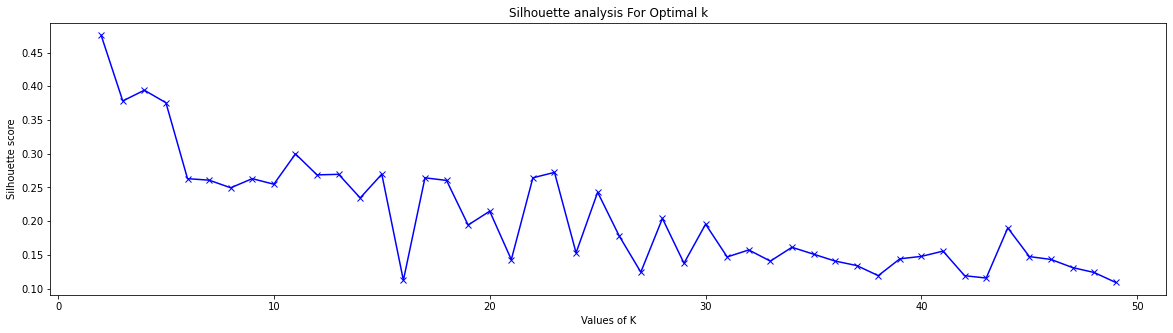

2


In [ ]:
plt.figure(figsize=(20,5))
plt.plot(range_clusters,silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()
best_num_cluster = range_clusters[silhouette_avg.index(np.max(silhouette_avg))]
print(best_num_cluster)

It shows the optimal number of clusters is around 15-16

In [ ]:
cluster = KMeans(n_clusters=15)
cluster.fit(fembeddings)

KMeans(n_clusters=15)

In [ ]:
pca = PCA(n_components=2)
pca_comps = pca.fit_transform(fembeddings)

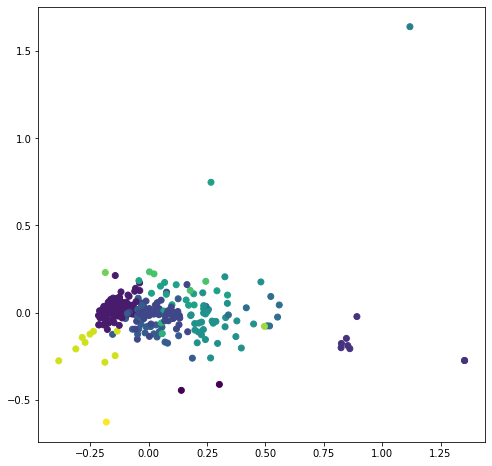

In [ ]:
fig = plt.figure(figsize=(8,8))
scatterplt = plt.scatter(pca_comps[:, 0], pca_comps[:, 1], c=cluster.labels_)


### Clustering Summary
*  Used K-Means clustering method to generated clusters from the embeddings.
*  Used PCA dimensionality reduction technique to generate 2 components to visualize the clusters 

# Evaluating the clusters

## Using Topic Modeling

In [ ]:
datadfcombined= datadfcombined.rename(columns={'Original food Item': 'Doc'})
docs_df = pd.DataFrame(datadfcombined, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))

In [ ]:
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(datadfcombined))

In [ ]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

In [ ]:
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

In [ ]:
datadfcombined['Topic'] = cluster.labels_

### Example1: Topic 13

Top words in topic 13

In [ ]:
top_n_words[13][:6]

[('teriyaki', 0.06375167910574095),
 ('noodles', 0.05934135346852731),
 ('soba', 0.05795841047284171),
 ('japanese', 0.05795841047284171),
 ('mein', 0.05795841047284171),
 ('pao', 0.05795841047284171)]

Restaurants in topic 13

In [ ]:
datadfcombined.query("Topic == 13")

,Restaurant Name,Doc,Topic
133,HoSan,buckwhet japanese noodle oriental roasted seaw...,13
134,Hokan,baby bamboo chestnuts chinese cocktail corn fi...,13
148,KA-ME,barbecue bean black brown cheese chestnuts chi...,13
157,Kojo,chipotle cracked ginger jerky pepper plantbase...,13
159,Koyo,asian black brown buckwheat cake cakes coconut...,13
171,Magic Wok,beef bowl broccoli brown chicken curry deluxe ...,13
190,Moe's Southwest Grill,bowl breakfast carnitas chicken chilaquiles po...,13
288,Tai Pei,battered beans beef broccoli burrito chicken c...,13
335,Wow Bao,asian bao bbq beef buns chicken chinese hot ku...,13


### Example2: Topic 10

Top words in topic 13

In [ ]:
top_n_words[10][:6]

[('italian', 0.29575039767564515),
 ('genovese', 0.23327529909134068),
 ('rigate', 0.20554941186894288),
 ('pasta', 0.20288364890233504),
 ('linguine', 0.1893308075446163),
 ('penne', 0.1893308075446163)]

Restaurants in topic 10

In [ ]:
datadfcombined.query("Topic == 10")

,Restaurant Name,Doc,Topic
103,Fanny's,dressing italian meat original pasta sauce,10
105,Five Guys,marinara sauce,10
106,Fratelli Mantova,basil genovese italian linguine organic pasta ...,10
230,Prima Familia,italian meatballs premium style,10


### Evaluating the clusters Summary
*  Since the embedding model was trained on a dataset of cuisines, clusters of restaurants with related cuisines were formed.
*  Used topic modeling technique to identify the type of cluster by using the top words.
*  Example 1 : The top words in Topic 13 are "teriyaki","noodles" and "soba," hence all japanese restaurants were chosen for this cluster.
*  Example 2 :The top words in Topic 13 are "rigate" , "pasta", "linguine" and "penne" hence all italian restaurants were chosen for this cluster.
